In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


# Introduction

The U-Net model is a simple fully  convolutional neural network that is used for binary segmentation i.e foreground and background pixel-wise classification. Mainly, it consists of two parts. 

*   Contracting Path: we apply a series of conv layers and downsampling layers  (max-pooling) layers to reduce the spatial size 
*   Expanding Path: we apply a series of upsampling layers to reconstruct the spatial size of the input. 

The two parts are connected using a concatenation layers among different levels. This allows learning different features at different levels. At the end we have a simple conv 1x1 layer to reduce the number of channels to 1. 


![alt text](https://blog.playment.io/wp-content/uploads/2018/03/Screen-Shot-2018-09-05-at-3.00.03-PM.png)

# Imports

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from tensorflow.keras.layers import  Dropout, Activation
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy
from tensorflow.keras.utils import plot_model, to_categorical


import glob
import random
import cv2
from random import shuffle

Using TensorFlow backend.


In [3]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xvzf images.tar.gz && tar -xvzf annotations.tar.gz
!rm  images/*.mat

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
annotations/trimaps/pomeranian_180.png
annotations/trimaps/._pomeranian_181.png
annotations/trimaps/pomeranian_181.png
annotations/trimaps/._pomeranian_182.png
annotations/trimaps/pomeranian_182.png
annotations/trimaps/._pomeranian_183.png
annotations/trimaps/pomeranian_183.png
annotations/trimaps/._pomeranian_184.png
annotations/trimaps/pomeranian_184.png
annotations/trimaps/._pomeranian_185.png
annotations/trimaps/pomeranian_185.png
annotations/trimaps/._pomeranian_186.png
annotations/trimaps/pomeranian_186.png
annotations/trimaps/._pomeranian_187.png
annotations/trimaps/pomeranian_187.png
annotations/trimaps/._pomeranian_188.png
annotations/trimaps/pomeranian_188.png
annotations/trimaps/._pomeranian_189.png
annotations/trimaps/pomeranian_189.png
annotations/trimaps/._pomeranian_19.png
annotations/trimaps/pomeranian_19.png
annotations/trimaps/._pomeranian_190.png
annotations/trimaps/pomeranian_190.png
annotations/trimaps/._pomeranian_191.png
annota

# Generators

In [6]:
def image_generator(files, batch_size = 32, sz = (256, 256)):
  
  while True: 
    
    #extract a random batch 
    batch = np.random.choice(files, size = batch_size)    
    
    #variables for collecting batches of inputs and outputs 
    batch_x = []
    batch_y = []
    
    for f in batch:

        #get the masks. Note that masks are png files 
        mask = Image.open(f'annotations/trimaps/{f[:-4]}.png')
        mask = np.array(mask.resize(sz))

        #preprocess the mask 
        mask[mask >= 2] = 0 
        mask[mask != 0 ] = 1
        
        batch_y.append(mask)

        #preprocess the raw images 
        raw = Image.open(f'images/{f}')
        raw = raw.resize(sz)
        raw = np.array(raw)

        #check the number of channels because some of the images are RGBA or GRAY
        if len(raw.shape) == 2:
          raw = np.stack((raw,)*3, axis=-1)

        else:
          raw = raw[:,:,0:3]

        batch_x.append(raw)

    #preprocess a batch of images and masks 
    batch_x = np.array(batch_x)/255.
    batch_y = np.array(batch_y)

    batch_y = to_categorical(batch_y)
    # (20, 256, 256, 1) --> (20, 256, 256, 2)

    yield (batch_x, batch_y)      
    

In [7]:
batch_size = 32 

all_files = os.listdir('images')
shuffle(all_files)

split = int(0.95 * len(all_files))

#split into training and testing
train_files = all_files[0:split]
test_files  = all_files[split:]

train_generator = image_generator(train_files, batch_size = batch_size)
test_generator  = image_generator(test_files, batch_size = batch_size)

FileNotFoundError: [WinError 3] 지정된 경로를 찾을 수 없습니다: 'images'

In [ ]:
x, y= next(train_generator)

In [ ]:
print (x.shape, y.shape)

In [ ]:
plt.axis('off')
img = x[0]
# img (256, 256, 3)
msk = y[0]
# mask (256, 256, 2)

msk = msk[:,:,1]
# msk[:,:,0] --> 배경이 1, 물체가 0
# msk[:,:,1] --> 배경이 0, 물체가 1
# msk (256, 256, 2) -> (256, 256)

msk = np.stack((msk,)*3, axis=-1)
plt.imshow( np.concatenate([img, msk, img*msk], axis = 1))

# IoU metric

The intersection over union (IoU) metric is a simple metric used to evaluate the performance of a segmentation algorithm. Given two masks $x_{true}, x_{pred}$ we evaluate 

$$IoU = \frac{y_{true} \cap y_{pred}}{y_{true} \cup y_{pred}}$$

In [11]:
def dice_coef(y_true, y_pred, smooth=1):
    y_pred = K.argmax(y_pred, axis=-1)
    y_true = y_true[:,:,:,1]

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    y_true_f = K.cast(y_true_f, 'float32')
    y_pred_f = K.cast(y_pred_f, 'float32')

    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_pred = K.argmax(y_pred, axis=-1)
    y_true = y_true[:,:,:,1]
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    y_true_f = K.cast(y_true_f, 'float32')
    y_pred_f = K.cast(y_pred_f, 'float32')
    
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return categorical_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

In [12]:
def block_residual(x, nKernels):
  identity = x
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(nKernels, 3, activation=None, kernel_initializer='he_normal', padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(nKernels, 3, activation=None, kernel_initializer='he_normal', padding='same')(x)
  
  return x + identity


# Model

In [13]:
def unet(sz = (256, 256, 3)):
  x = Input(sz)
  # x = Input(batch_shape=(32, 256, 256, 3))
  inputs = x
  
  #Contracting layers
  nKernels = 8
  layers = []

  # level_1 (256, 256, 3)
  encoding = Conv2D(nKernels, 1, activation=None, use_bias=True, kernel_initializer='he_normal', padding='same') (x) 

  layer11 = Conv2D(nKernels, 3, activation=None, use_bias=False, kernel_initializer='he_normal', padding='same') (encoding)
  # level_1 (256, 256, 3) -> (256, 256, 8)
  layer11 = BatchNormalization()(layer11)
  layer11 = LeakyReLU()(layer11)
  layer12 = Conv2D(nKernels, 3, activation=None, kernel_initializer='he_normal', padding='same') (layer11)
  # (256, 256, 3) + (256, 256, 3)
  layer12 = layer12 + encoding
  layers.append(layer12)
  layer13 = MaxPooling2D() (layer12)

  # level_2 (128, 128, 3)
  layer13 = Conv2D(nKernels*2, 1, activation=None, use_bias=True, kernel_initializer='he_normal', padding='same') (layer13)
  layer21 = block_residual(layer13, nKernels*2)
  layers.append(layer21)
  layer21 = MaxPooling2D() (layer21)


  # level_3 (64, 64, 32)
  layer21 = Conv2D(nKernels*4, 1, activation=None, use_bias=True, kernel_initializer='he_normal', padding='same') (layer21)
  layer31 = block_residual(layer21, nKernels*4)
  layers.append(layer31)
  layer31 = MaxPooling2D() (layer31)

  # level_4 (32, 32, 64)
  layer31 = Conv2D(nKernels*8, 1, activation=None, use_bias=True, kernel_initializer='he_normal', padding='same') (layer31)
  layer41 = block_residual(layer31, nKernels*8)
  layers.append(layer41)
  layer41 = MaxPooling2D()(layer41)

  # level_5 (16, 16, 128)
  layer41 = Conv2D(nKernels*16, 1, activation=None, use_bias=True, kernel_initializer='he_normal', padding='same') (layer41)
  layer51 = block_residual(layer41, nKernels*16)
  layers.append(layer51)
  layer51 = MaxPooling2D()(layer51)

  # level_6 (8, 8, 256)
  layer51 = Conv2D(nKernels*32, 1, activation=None, use_bias=True, kernel_initializer='he_normal', padding='same') (layer51)
  layer61 = block_residual(layer51, nKernels*32)
  layers.append(layer61)
  layer61 = MaxPooling2D()(layer61)

  # BottleNeck (4, 4, 512)
  bottleneck11 = Conv2D(nKernels*64, 3, activation='relu', kernel_initializer='he_normal', padding='same') (layer61)
  bottleneck11 = Dropout(0.2)(bottleneck11)
  bottleneck12 = Conv2D(nKernels*128, 3, activation='relu', kernel_initializer='he_normal', padding='same') (bottleneck11)
  bottleneck12 = Dropout(0.2)(bottleneck12)
  bottleneck13 = Conv2DTranspose(nKernels*64, 2, strides=(2, 2), kernel_initializer='he_normal', padding='same') (bottleneck12)
  # (8, 8, 256)
  level = len(layers) - 1
  layer71 = Concatenate(axis=3)([bottleneck13, layers[level]])
  
  # level 7 = level 6
  layer71 = Conv2D(nKernels*64, 1, activation=None, use_bias=True, kernel_initializer='he_normal', padding='same') (layer71)
  layer71 = block_residual(layer71, nKernels*64)
  layer72 = Conv2DTranspose(nKernels*32, 2, strides=(2, 2), kernel_initializer='he_normal',  padding='same') (layer71)
  level = len(layers) - 2
  layer81 = Concatenate(axis=3)([layer72, layers[level]])
  
  # level 8 = level 5
  layer81 = Conv2D(nKernels*32, 1, activation=None, use_bias=True, kernel_initializer='he_normal', padding='same') (layer81)
  layer81 = block_residual(layer81, nKernels*32)
  layer82 = Conv2DTranspose(nKernels*16, 2, strides=(2, 2), kernel_initializer='he_normal',  padding='same') (layer81)
  level = len(layers) - 3
  layer91 = Concatenate(axis=3)([layer82, layers[level]])

  # level 9 = level 4
  layer91 = Conv2D(nKernels*16, 1, activation=None, use_bias=True, kernel_initializer='he_normal', padding='same') (layer91)
  layer91 = block_residual(layer91, nKernels*16)
  layer92 = Conv2DTranspose(nKernels*8, 2, strides=(2, 2), kernel_initializer='he_normal', padding='same') (layer91)
  level = len(layers) - 4
  layer101 = Concatenate(axis=3)([layer92, layers[level]])

  # level 10 = level 3
  layer101 = Conv2D(nKernels*8, 1, activation=None, use_bias=True, kernel_initializer='he_normal', padding='same') (layer101)
  layer101 = block_residual(layer101, nKernels*8)
  layer102 = Conv2DTranspose(nKernels*4, 2, strides=(2, 2), kernel_initializer='he_normal',  padding='same') (layer101)
  level = len(layers) - 5
  layer111 = Concatenate(axis=3)([layer102, layers[level]])
  
  # level 11 = level 2
  layer111 = Conv2D(nKernels*4, 1, activation=None, use_bias=True, kernel_initializer='he_normal', padding='same') (layer111)
  layer111 = block_residual(layer111, nKernels*4)
  layer112 = Conv2DTranspose(nKernels*2, 2, strides=(2, 2), kernel_initializer='he_normal',  padding='same') (layer111)
  level = len(layers) - 6
  layer121 = Concatenate(axis=3)([layer112, layers[level]])
      
  #level 1 = classification 
  classification1 = Conv2D(nKernels, 3, activation='relu', kernel_initializer='he_normal', padding='same') (layer121)
  classification1 = Dropout(0.25)(classification1)
  classification2 = Conv2D(nKernels, 3, activation='relu', kernel_initializer='he_normal', padding='same') (classification1)
  outputs = Conv2D(2, 1, activation='softmax') (classification2)
  
  #model creation 
  model = Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer = 'rmsprop', loss = bce_dice_loss, metrics = [dice_coef])
  
  return model

In [14]:
model = unet()

In [15]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 256, 256, 8)  32          input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 256, 256, 8)  576         conv2d_38[0][0]                  
__________________________________________________________________________________________________
batch_normalization_21 (BatchNo (None, 256, 256, 8)  32          conv2d_39[0][0]                  
____________________________________________________________________________________________

In [0]:
def build_callbacks():
        checkpointer = ModelCheckpoint(filepath='unet.h5', verbose=0, save_best_only=True, save_weights_only=True)
        callbacks = [checkpointer, PlotLearning()]
        return callbacks

# inheritance for training process plot 
class PlotLearning(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        self.logs = []
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('dice_coef'))
        self.val_acc.append(logs.get('val_dice_coef'))
        self.i += 1
        print('i=',self.i,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'),
        'mean_dsc=',logs.get('dice_coef'),'val_mean_dsc=',logs.get('val_dice_coef'))
        
        #choose a random test image and preprocess
        path = np.random.choice(test_files)
        raw = Image.open(f'images/{path}')
        raw = np.array(raw.resize((256, 256)))/255.
        raw = raw[:,:,0:3]
        
        #predict the mask 
        pred = model.predict(np.expand_dims(raw, 0))
        # input --> (1, 256,256, 3)
        # shape of pred --> (1, 256, 256, 2)
        
        msk = np.argmax(pred, axis=-1)
        # (1, 256, 256, 2) -> (1, 256, 256)
        msk  = msk.squeeze()
        # (1, 256, 256) --> (256, 256)
        msk = np.stack((msk,)*3, axis=-1)
        # (256, 256) --> (256, 256, 3)
        
        #show the mask and the segmented image 
        combined = np.concatenate([raw, msk, raw* msk], axis = 1)
        plt.axis('off')
        plt.imshow(combined)
        plt.show()

In [23]:
train_steps = len(train_files) //batch_size
test_steps = len(test_files) //batch_size
print (train_steps, test_steps)

219 11


i= 1 loss= 1.284590757600793 val_loss= 0.7157190225341103 mean_dsc= 0.31613263 val_mean_dsc= 0.7187989


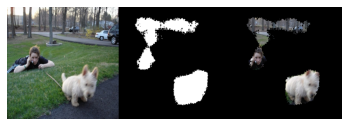

i= 2 loss= 0.6198536450187909 val_loss= 0.6533102122220126 mean_dsc= 0.7549866 val_mean_dsc= 0.73076993


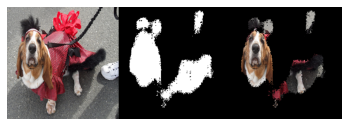

i= 3 loss= 0.49345710220402234 val_loss= 0.4946123551238667 mean_dsc= 0.8129305 val_mean_dsc= 0.8188719


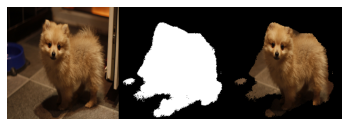

i= 4 loss= 0.42845983292958506 val_loss= 0.4351942620494149 mean_dsc= 0.8363518 val_mean_dsc= 0.8416957


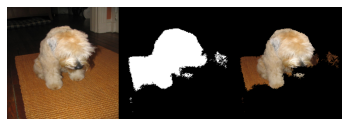

i= 5 loss= 0.3809012518897993 val_loss= 0.42502251809293573 mean_dsc= 0.85346586 val_mean_dsc= 0.83031183


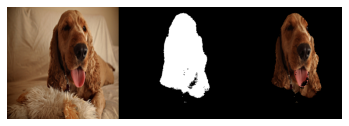

i= 6 loss= 0.34009359395939465 val_loss= 0.39140044017271564 mean_dsc= 0.8677174 val_mean_dsc= 0.8384575


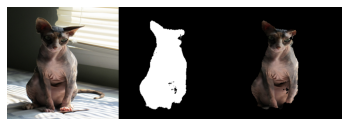

i= 7 loss= 0.3184213499500327 val_loss= 0.3596436354247006 mean_dsc= 0.87552905 val_mean_dsc= 0.862897


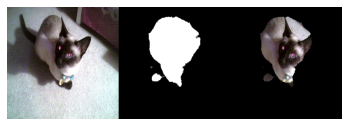

i= 8 loss= 0.2877530250102962 val_loss= 0.4251611720431935 mean_dsc= 0.88737565 val_mean_dsc= 0.8316885


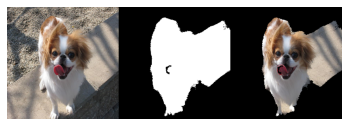

i= 9 loss= 0.2729695556370635 val_loss= 0.38258440657095477 mean_dsc= 0.89206123 val_mean_dsc= 0.8504524


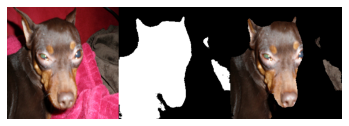

i= 10 loss= 0.25609950360642175 val_loss= 0.37890399315140466 mean_dsc= 0.89907885 val_mean_dsc= 0.8430706


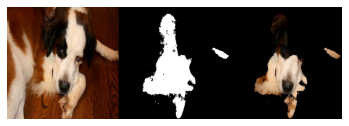

i= 11 loss= 0.24299632250990497 val_loss= 0.32757807590744714 mean_dsc= 0.90399754 val_mean_dsc= 0.86730486


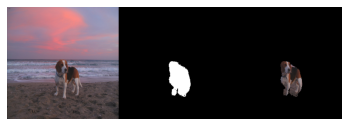

i= 12 loss= 0.23210199435824128 val_loss= 0.35057826746593823 mean_dsc= 0.90778035 val_mean_dsc= 0.86559904


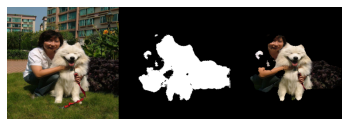

i= 13 loss= 0.21582051642137032 val_loss= 0.33036417852748523 mean_dsc= 0.91488034 val_mean_dsc= 0.870229


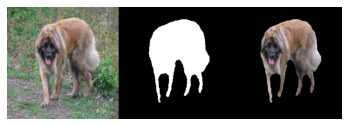

i= 14 loss= 0.2031756386364976 val_loss= 0.28488286516883154 mean_dsc= 0.9192591 val_mean_dsc= 0.8851461


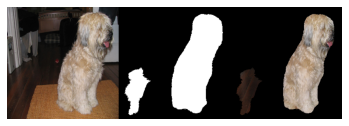

i= 15 loss= 0.1979826809200522 val_loss= 0.3242981352589347 mean_dsc= 0.9206266 val_mean_dsc= 0.87046885


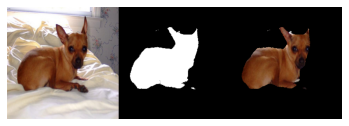

i= 16 loss= 0.19028668636328552 val_loss= 0.3111609464341944 mean_dsc= 0.92314774 val_mean_dsc= 0.8757587


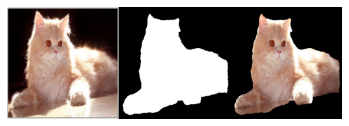

i= 17 loss= 0.1825477686374699 val_loss= 0.3659626678986983 mean_dsc= 0.92662674 val_mean_dsc= 0.85993963


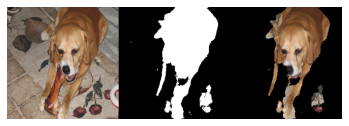

i= 18 loss= 0.17744198380267784 val_loss= 0.3141470050269907 mean_dsc= 0.9286353 val_mean_dsc= 0.878392


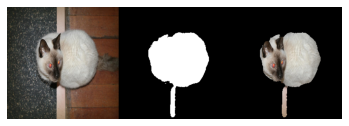

i= 19 loss= 0.16809698820250218 val_loss= 0.32807007702914154 mean_dsc= 0.9314093 val_mean_dsc= 0.8730955


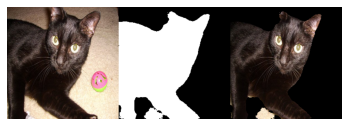

i= 20 loss= 0.1670695799806891 val_loss= 0.2845646264878186 mean_dsc= 0.932462 val_mean_dsc= 0.88537407


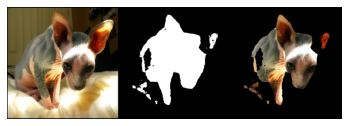

i= 21 loss= 0.15761792690378346 val_loss= 0.29886249791492114 mean_dsc= 0.935658 val_mean_dsc= 0.878978


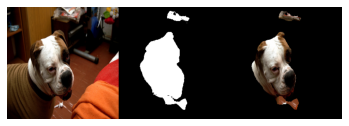

i= 22 loss= 0.15507869640169622 val_loss= 0.301743054931814 mean_dsc= 0.9369698 val_mean_dsc= 0.87996984


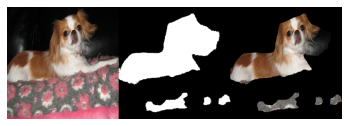

i= 23 loss= 0.15171632898724788 val_loss= 0.299460462548516 mean_dsc= 0.93819684 val_mean_dsc= 0.8829098


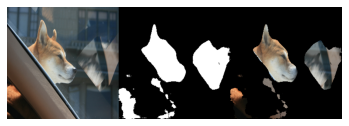

i= 24 loss= 0.14621805644606892 val_loss= 0.3013641969724135 mean_dsc= 0.94045526 val_mean_dsc= 0.87671816


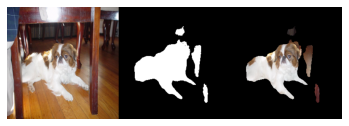

i= 25 loss= 0.14438731148498787 val_loss= 0.3053737919438969 mean_dsc= 0.94106644 val_mean_dsc= 0.88146996


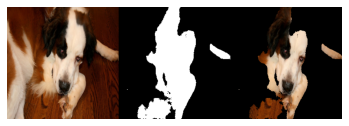

i= 26 loss= 0.1385704608948808 val_loss= 0.26584261791272595 mean_dsc= 0.9429845 val_mean_dsc= 0.8936827


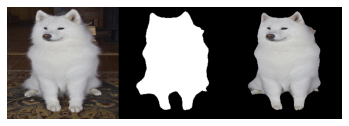

i= 27 loss= 0.13505899685022493 val_loss= 0.3050559718500484 mean_dsc= 0.9447347 val_mean_dsc= 0.8799357


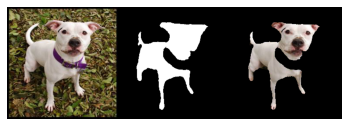

i= 28 loss= 0.1314835369450861 val_loss= 0.2794708094813607 mean_dsc= 0.94603086 val_mean_dsc= 0.89071333


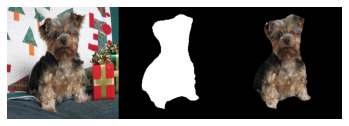

i= 29 loss= 0.1292913343128004 val_loss= 0.28423699601130054 mean_dsc= 0.9470318 val_mean_dsc= 0.88721365


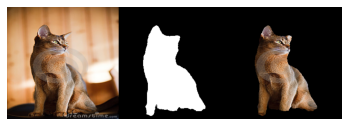

i= 30 loss= 0.12640075069176007 val_loss= 0.30054898830977356 mean_dsc= 0.94806194 val_mean_dsc= 0.8926063


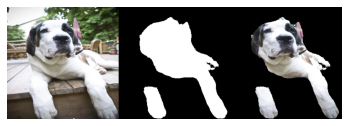

In [29]:
model.fit_generator(train_generator, 
                    epochs = 30, steps_per_epoch = train_steps, validation_data = test_generator, validation_steps = test_steps,
                    callbacks = build_callbacks(), verbose = 0)

# Testing

In [25]:
!wget http://r.ddmcdn.com/s_f/o_1/cx_462/cy_245/cw_1349/ch_1349/w_720/APL/uploads/2015/06/caturday-shutterstock_149320799.jpg -O test.jpg

--2020-05-08 11:38:18--  http://r.ddmcdn.com/s_f/o_1/cx_462/cy_245/cw_1349/ch_1349/w_720/APL/uploads/2015/06/caturday-shutterstock_149320799.jpg
Resolving r.ddmcdn.com (r.ddmcdn.com)... 99.86.38.68, 99.86.38.73, 99.86.38.15, ...
Connecting to r.ddmcdn.com (r.ddmcdn.com)|99.86.38.68|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63219 (62K) [image/jpeg]
Saving to: ‘test.jpg’

test.jpg            100%[===================>]  61.74K  --.-KB/s    in 0.01s   

2020-05-08 11:38:18 (6.12 MB/s) - ‘test.jpg’ saved [63219/63219]



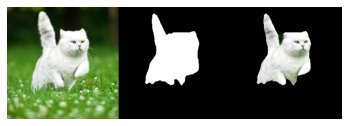

In [30]:
raw = Image.open('test.jpg')
raw = np.array(raw.resize((256, 256)))/255.
raw = raw[:,:,0:3]

#predict the mask 
pred = model.predict(np.expand_dims(raw, 0))

#mask post-processing 
# msk  = pred.squeeze()
# msk = np.stack((msk,)*3, axis=-1)
# msk[msk >= 0.5] = 1 
# msk[msk < 0.5] = 0 

msk = np.argmax(pred, axis=-1)
# (1, 256, 256)
msk  = msk.squeeze()
# (256, 256)
msk = np.stack((msk,)*3, axis=-1)
# (256, 256, 3)

#show the mask and the segmented image 
combined = np.concatenate([raw, msk, raw* msk], axis = 1)
plt.axis('off')
plt.imshow(combined)
plt.show()

# References


1.   http://deeplearning.net/tutorial/unet.html
2.   https://github.com/ldenoue/keras-unet

